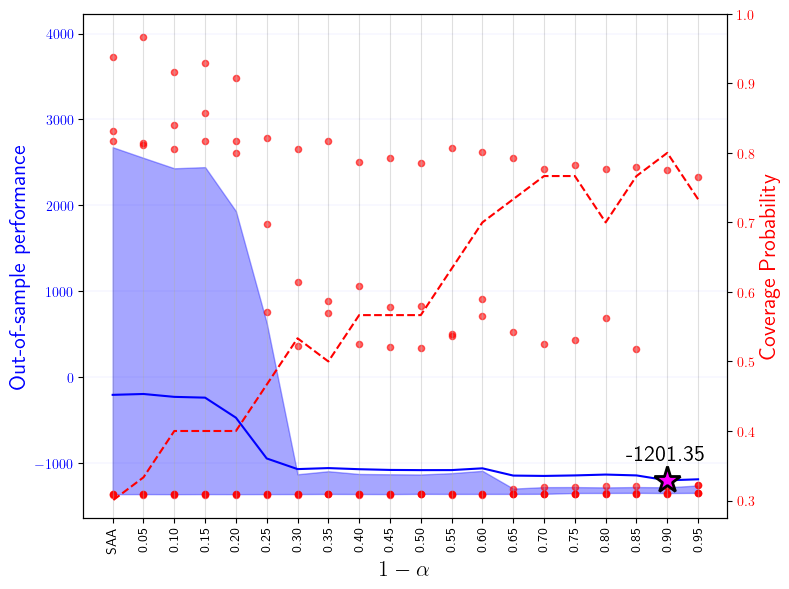

In [ ]:
import matplotlib.pyplot as plt
import json
import numpy as np 
from matplotlib.font_manager import FontProperties
save_path = "apub_results_ee60.json"
with open(save_path, "r") as f:
    loaded_results = json.load(f)

# 把 key 转回 float
results = {
    float(alpha): vals for alpha, vals in loaded_results.items()
}
try:
    plt.rcParams["text.usetex"] = True
    plt.rcParams["text.latex.preamble"] = r"\usepackage{amsmath}"
except Exception:
    print("Warning: LaTeX not found, using default text rendering.")
    plt.rcParams["text.usetex"] = False
bold_times = FontProperties(family='Times New Roman', size=16, weight='bold')
alpha_list = sorted(results.keys())
x_vals = [1 - a for a in alpha_list] # 横轴是 1 - alpha
# 将所有 alpha 下的成本结果整理为二维数组 (K trials × len(alpha_list))
cost_matrix = np.array([results[a]['costs'] for a in alpha_list])  # shape: (len_alpha, K)
cost_matrix = cost_matrix.T  # shape: (K, len_alpha)

mean_costs = np.mean(cost_matrix, axis=0)
lower_quantile = np.quantile(cost_matrix, 0.1, axis=0)
upper_quantile = np.quantile(cost_matrix, 0.9, axis=0)

coverage = [np.mean(results[a]['reliabilities']) for a in alpha_list]

best_idx = np.argmin(mean_costs)
best_x = x_vals[best_idx]
best_y = mean_costs[best_idx]

fig, ax1 = plt.subplots(figsize=(8, 6))
ax1.plot(x_vals, mean_costs, 'b-', label='Average Loss')
ax1.fill_between(x_vals, lower_quantile, upper_quantile, alpha=0.35, color='blue')
# === 标出 outliers ===
for j, a in enumerate(alpha_list):
    q10, q90 = lower_quantile[j], upper_quantile[j]
    outliers = [c for c in results[a]['costs'] if (c < q10 or c > q90)]
    if outliers:  # 用红色小点标出
        ax1.scatter([x_vals[j]]*len(outliers), outliers,
                    color='red', s=20, alpha=0.6, label='_nolegend_')

ax1.plot(best_x, best_y, marker='*', markersize=20,
        markeredgecolor='black', markeredgewidth=2,
        color='magenta', label='Lowest Mean', linestyle='None')
# ax1.set_yticks([4000, 6000, 8000, 10000, 12000, 14000, 16000, 18000])
ax1.set_xticks(x_vals)

index_of_zero = x_vals.index(0.0)
str_nums = [f"{x:.2f}" for x in x_vals]
str_nums[index_of_zero] = 'SAA'
ax1.set_xticklabels(str_nums, rotation=90)

ax1.annotate(f'{best_y:.2f}', xy=(best_x, best_y), xytext=(-30, 15),textcoords='offset points',
            color='black', fontsize=16)
ax1.set_xlabel(r'$1-\alpha$', fontproperties=bold_times)
ax1.set_ylabel("Out-of-sample performance", color='blue', fontproperties=bold_times)

ax1.tick_params(axis='y', labelcolor='blue')

ax1.grid(which='major', alpha=0.4)
ax1.grid(which='minor', alpha=0.2)

# Set the horizontal grid to blue
ax1.yaxis.grid(True, color='blue', linestyle='-', linewidth=0.1)

ax2 = ax1.twinx()
ax2.plot(x_vals, coverage, 'r--', label='Coverage Probability')
ax2.set_yticks([0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
ax2.set_ylabel('Coverage Probability', color='red', fontproperties=bold_times)
ax2.tick_params(axis='y', labelcolor='red')

fig.tight_layout()
plt.show()